# imports

In [2]:
import pickle
from srgnn_pl import SRGNN_model, SRGNN_Map_Dataset, SRGNN_sampler
from utils import fake_parser
import torch
import os

from torch.utils.data import DataLoader
import pytorch_lightning as pl

import numpy as np

In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import yaml
from math import ceil
from sklearn.mixture import GaussianMixture
from IPython.display import clear_output

In [4]:
torch.set_float32_matmul_precision('medium')

# data loading

In [5]:
#global_run_id='run-20240209_162656-h23ej73g'

finetuned_run_id='run-20240213_043223-0zuvfc9x'
global_run_id=finetuned_run_id

In [6]:
with open(f"./wandb/{global_run_id}/files/config.yaml", "r") as stream:
        config=yaml.safe_load(stream)

keys=list(config.keys())
for k in keys:
    if k not in fake_parser().__dict__.keys():
        del config[k]
    else:
        config[k]=config[k]['value']

opt=fake_parser(**config)
print(opt.__dict__)

model=SRGNN_model.load_from_checkpoint(f"./GNN_master/{global_run_id.split('-')[-1]}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{global_run_id.split('-')[-1]}/checkpoints/")[0], opt=opt)

{'dataset': 'yoochoose_custom', 'batchSize': 128, 'hiddenSize': 64, 'epoch': 60, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 3, 'l2': 1e-05, 'step': 3, 'patience': 6, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.2, 'pretrained_embedings': True, 'unfreeze_epoch': 2}


In [7]:
#with open(f'./gmm_all_32_k-means++_{opt.hiddenSize}.gmm', 'rb') as gmm_file:
with open(f'./gmm_better_32_k-means++_{opt.hiddenSize}.gmm', 'rb') as gmm_file:
    gm=pickle.load(gmm_file)
#    session_labels=gm.predict(session_emb)

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianMixture from version 1.3.2 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))
test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)
test_dataloader=DataLoader(test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(test_dataset, opt.batchSize, shuffle=False, drop_last=False),
                             drop_last=False
                            )

data masking start
data masking 1
data masking 2


100%|██████████| 64/64 [00:01<00:00, 61.70it/s]

done masking


# evaluate each cluster model

## all sessions

In [9]:
session_emb=[]

model.to('cuda')
for batch in tqdm(test_dataloader, total=test_dataset.length//opt.batchSize):
    batch=[b.to('cuda') for b in batch]
    session_emb.append(model.get_session_embeddings(batch).cpu().detach().numpy())
model.to('cpu')
session_emb=np.concatenate(session_emb)

1214it [00:10, 111.70it/s]                          


In [10]:
session_labels=[]
for i in tqdm(range(ceil(session_emb.shape[0]/opt.batchSize))):
    session_labels.append(gm.predict(session_emb[i*opt.batchSize: (i+1)*opt.batchSize]))
session_labels=np.concatenate(session_labels)

100%|██████████| 1214/1214 [00:01<00:00, 682.20it/s]


In [11]:
hit,mrr=[],[]
model.to('cuda')
for batch in tqdm(test_dataloader, total=test_dataset.length//opt.batchSize):
    batch=[b.to('cuda') for b in batch]
    sub_scores, targets=model.predict_step(batch)
    targets=targets.flatten()
    for score, target in zip(sub_scores, targets):
        correct_pred=torch.isin(target - 1, score).cpu()
        hit.append(correct_pred)
        if not correct_pred:
            mrr.append(0)
        else:
            mrr.append(1 / (torch.where(score == target - 1)[0][0] + 1).cpu())
model.to('cpu')
hit=np.array(hit)
mrr=np.array(mrr)

1214it [00:58, 20.91it/s]                          


### trained from scratch

In [28]:
runs_df=pd.read_csv('./wandb_export_raw_all.csv')
runs_df['cluster']=runs_df.Name.map(lambda x: int(x.split('_')[-1]))

In [29]:
cluster_results=[]
cluster_results.append(
{'cluster':-1, 
 'test_loss': np.nan,
 'test_hit': np.average(hit),
 'test_mrr': np.average(mrr)})

for c in tqdm(range(gm.n_components)):
    clear_output(wait=True)
    idxs=np.arange(len(test_data[0]))[session_labels==c]

    cluster_sess=[test_data[0][i] for i in idxs]
    cluster_targets=[test_data[1][i] for i in idxs]
    cluster_data=(cluster_sess,cluster_targets)
    cluster_dataset=SRGNN_Map_Dataset(cluster_data, shuffle=False)
    cluster_dataloader=DataLoader(cluster_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(cluster_dataset, opt.batchSize, shuffle=False, drop_last=False),
                             drop_last=False
                            )
    run_id=runs_df.loc[runs_df.cluster==c].ID.item()
    cluster_model=SRGNN_model.load_from_checkpoint(f"./GNN_master/{run_id}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{run_id}/checkpoints/")[0], opt=opt)
    
    trainer=pl.Trainer(limit_test_batches=ceil(cluster_dataset.length/opt.batchSize),limit_predict_batches=ceil(cluster_dataset.length/opt.batchSize))
    metrics=trainer.test(cluster_model, cluster_dataloader)[0]#only one dataloader
    metrics['cluster']=c
    metrics['global_model_hit']=100*np.average(hit[idxs])
    metrics['global_model_mrr']=100*np.average(mrr[idxs])
    cluster_results.append(metrics)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


data masking start
data masking 1
data masking 2
data masking 3
done masking


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_hit          │     63.52531051635742     │
│         test_loss         │     5.713991641998291     │
│         test_mrr          │    26.996490478515625     │
└───────────────────────────┴───────────────────────────┘

100%|██████████| 32/32 [01:20<00:00,  2.50s/it]


In [30]:
cluster_results=pd.DataFrame(cluster_results)
cluster_results

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr
0,-1,NaN,0.553531,0.248305,NaN,NaN
1,0,6.621505,51.548405,23.252512,53.329782,24.557642
2,1,6.454111,45.515423,18.264372,47.145589,19.081339
3,2,6.628732,40.922070,14.518913,44.805195,16.413542
4,3,6.079962,63.917828,30.493874,64.709763,30.852930
5,4,8.367682,45.151176,20.737585,51.160433,22.815957
6,5,5.501886,68.205498,35.135696,70.256024,34.819782
7,6,6.545033,54.092262,23.490585,57.482599,25.490220
8,7,5.627601,64.603004,26.756392,66.477987,28.742248
9,8,5.816460,60.559658,25.042292,63.295019,26.194494


In [32]:
(cluster_results.test_hit>cluster_results.global_model_hit).any(), (cluster_results.test_mrr>cluster_results.global_model_mrr).any()

(False, True)

In [34]:
cluster_results.iloc[np.arange(cluster_results.shape[0])[cluster_results.test_mrr>cluster_results.global_model_mrr]]

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr
6,5,5.501886,68.205498,35.135696,70.256024,34.819782


In [36]:
cluster_results.loc[cluster_results.global_model_hit<100*np.average(hit)]

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr
1,0,6.621505,51.548405,23.252512,53.329782,24.557642
2,1,6.454111,45.515423,18.264372,47.145589,19.081339
3,2,6.628732,40.922070,14.518913,44.805195,16.413542
5,4,8.367682,45.151176,20.737585,51.160433,22.815957
13,12,6.043377,54.361897,22.599600,55.291622,23.257653
16,15,7.424316,36.012962,16.525658,42.018538,19.445396
17,16,9.478106,28.735292,10.815783,35.063694,14.230315
18,17,6.353772,48.304508,22.010084,50.141163,22.443078
21,20,8.149501,38.733315,16.378510,51.173896,22.492508
24,23,12.635973,14.129725,4.684999,21.082391,7.414331


## full sessions

In [124]:
full_session_emb=[]
full_sessions=[]
for batch in tqdm(test_dataloader, total=test_dataset.length//opt.batchSize):
    # use only original sessions
    a=batch[3][0]
    a=torch.vstack([torch.zeros(a.shape[1]), a])
    idxs=torch.diff(a, dim=0).sum(axis=1)
    for i in range(len(batch)):
        batch[i]=batch[i][:,idxs>0]
    #print(batch[0].shape)
    #break
    full_sessions.append(batch)
    full_session_emb.append(model.get_session_embeddings(batch).detach().numpy())
full_session_emb=np.concatenate(full_session_emb)

152it [00:13, 11.67it/s]                         


In [125]:
full_session_labels=gm.predict(full_session_emb)

In [126]:
len(full_session_labels)

34034

In [127]:
hit,mrr=[],[]
for batch in tqdm(full_sessions):
    sub_scores, targets=model.predict_step(batch)
    targets=targets.flatten()
    for score, target in zip(sub_scores, targets):
        correct_pred=torch.isin(target - 1, score)
        hit.append(correct_pred)
        if not correct_pred:
            mrr.append(0)
        else:
            mrr.append(1 / (torch.where(score == target - 1)[0][0] + 1))
hit=np.array(hit)
mrr=np.array(mrr)

100%|██████████| 152/152 [00:12<00:00, 12.41it/s]


In [129]:
full_sess_results=[]
full_sess_results.append(
{'cluster':-1, 
 'global_model_hit': np.average(hit),
 'global_model_mrr': np.average(mrr)})

for c in tqdm(range(gm.n_components)):
    clear_output(wait=True)
    idxs=full_session_labels==c

    run_id=runs_df.loc[runs_df.cluster==c].ID.item()
    cluster_model=SRGNN_model.load_from_checkpoint(f"./GNN_master/{run_id}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{run_id}/checkpoints/")[0], opt=opt)
    cluster_model.to('cpu')
    
    chit,cmrr=[],[]
    counter=0
    prev_batch=None
    for batch in (full_sessions):
        batch_idxs=idxs[counter:counter+batch[4].shape[-1]]
        counter+=batch[4].shape[-1]

        batch=[b[:, batch_idxs] for b in batch]
        

        sub_scores, targets=cluster_model.predict_step(batch)
        targets=targets.flatten()
        for score, target in zip(sub_scores, targets):
            correct_pred=torch.isin(target - 1, score)
            chit.append(correct_pred)
            if not correct_pred:
                cmrr.append(0)
            else:
                cmrr.append(1 / (torch.where(score == target - 1)[0][0] + 1))

    metrics={}
    metrics['cluster']=c
    metrics['model_hit']=100*np.average(chit)
    metrics['model_mrr']=100*np.average(cmrr)
    metrics['global_model_hit']=100*np.average(hit[idxs])
    metrics['global_model_mrr']=100*np.average(mrr[idxs])
    full_sess_results.append(metrics)

100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


In [131]:
full_sess_results=pd.DataFrame(full_sess_results)

In [136]:
full_sess_results.iloc[(full_sess_results.model_mrr>full_sess_results.global_model_mrr).values]

,cluster,test_loss,test_hit,test_mrr,model_hit,model_mrr,global_model_hit,global_model_mrr
10,9,NaN,NaN,NaN,61.501597,28.099945,62.616822,27.867965
15,14,NaN,NaN,NaN,68.902439,35.281173,68.471954,34.602202


In [135]:
full_sess_results.iloc[(full_sess_results.model_hit>full_sess_results.global_model_hit).values]

,cluster,test_loss,test_hit,test_mrr,model_hit,model_mrr,global_model_hit,global_model_mrr
15,14,NaN,NaN,NaN,68.902439,35.281173,68.471954,34.602202
26,25,NaN,NaN,NaN,63.004172,24.414224,62.054795,24.630326


# finetuned

## all sessions

In [12]:
runs_df=pd.read_csv('./wandb_export_gm_finetune_runs.csv')
runs_df['cluster']=runs_df.Name.map(lambda x: int(x.split('_')[-1]))

### evaluate models

In [13]:
cluster_results=[]
cluster_results.append(
{'cluster':-1, 
 'test_loss': np.nan,
 'test_hit': np.average(hit),
 'test_mrr': np.average(mrr)})

for c in tqdm(range(gm.n_components)):
    clear_output(wait=True)
    if runs_df.loc[runs_df.cluster==c].empty:
        continue
    idxs=np.arange(len(test_data[0]))[session_labels==c]

    cluster_sess=[test_data[0][i] for i in idxs]
    cluster_targets=[test_data[1][i] for i in idxs]
    cluster_data=(cluster_sess,cluster_targets)
    cluster_dataset=SRGNN_Map_Dataset(cluster_data, shuffle=False)
    cluster_dataloader=DataLoader(cluster_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(cluster_dataset, opt.batchSize, shuffle=False, drop_last=False),
                             drop_last=False
                            )
    run_id=runs_df.loc[runs_df.cluster==c].ID.item()
    cluster_model=SRGNN_model.load_from_checkpoint(f"./GNN_master/{run_id}/checkpoints/"+
                                       os.listdir(f"./GNN_master/{run_id}/checkpoints/")[0], opt=opt)
    
    trainer=pl.Trainer(limit_test_batches=ceil(cluster_dataset.length/opt.batchSize),limit_predict_batches=ceil(cluster_dataset.length/opt.batchSize))
    metrics=trainer.test(cluster_model, cluster_dataloader)[0]#only one dataloader
    metrics['cluster']=c
    metrics['global_model_hit']=100*np.average(hit[idxs])
    metrics['global_model_mrr']=100*np.average(mrr[idxs])
    cluster_results.append(metrics)

data masking start
data masking 1
data masking 2


100%|██████████| 64/64 [00:00<00:00, 1141.90it/s]

done masking



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 73/73 [00:03<00:00, 23.49it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             35.08748245239258
        test_loss            8.98015308380127
        test_mrr            15.542804718017578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


100%|██████████| 32/32 [01:08<00:00,  2.16s/it]


In [14]:
cluster_results=pd.DataFrame(cluster_results)
cluster_results=cluster_results.merge(pd.DataFrame(np.unique(session_labels, return_counts=True)).T.rename(columns={0:'cluster',1:'size'}),
                      on='cluster')

In [14]:
(cluster_results.test_hit>cluster_results.global_model_hit).any(), (cluster_results.test_mrr>cluster_results.global_model_mrr).any()

(True, True)

In [15]:
cluster_results.iloc[np.arange(cluster_results.shape[0])[cluster_results.test_mrr>cluster_results.global_model_mrr]]

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr,size
0,0,6.345438,46.706402,17.293476,47.368421,17.076397,5909
3,3,9.786974,32.537613,13.866294,30.728004,13.043829,2239
5,5,5.847559,61.718750,33.115646,62.188057,32.829809,4488
19,20,1.729631,92.307693,92.307693,92.307692,92.307692,52
24,25,5.962016,54.421932,26.047878,54.209524,25.839076,2625
28,29,6.521373,44.465172,16.526772,43.761028,16.370745,3967


In [16]:
cluster_results.iloc[np.arange(cluster_results.shape[0])[cluster_results.test_hit>cluster_results.global_model_hit]]

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr,size
3,3,9.786974,32.537613,13.866294,30.728004,13.043829,2239
19,20,1.729631,92.307693,92.307693,92.307692,92.307692,52
23,24,13.693072,18.772322,7.410641,17.639594,8.191401,788
24,25,5.962016,54.421932,26.047878,54.209524,25.839076,2625
27,28,6.638066,46.627441,21.624046,46.352941,21.992768,3400
28,29,6.521373,44.465172,16.526772,43.761028,16.370745,3967


In [17]:
session_labels.shape

(155292,)

In [18]:
cluster_results.loc[cluster_results.global_model_hit<np.average(hit)*100/1.25]

,cluster,test_loss,test_hit,test_mrr,global_model_hit,global_model_mrr,size
3,3,9.786974,32.537613,13.866294,30.728004,13.043829,2239
23,24,13.693072,18.772322,7.410641,17.639594,8.191401,788
28,29,6.521373,44.465172,16.526772,43.761028,16.370745,3967
30,31,8.980153,35.087482,15.542805,36.197637,15.979771,9310


## investigate on sessions types in each cluster

In [15]:
dfs=[]
for k in tqdm(range(33003945//int(1e6))):
    df=pd.read_table('../datasets/yoochoose-clicks.dat', sep=',', dtype=str,
                     nrows=int(1e6), skiprows=k*int(1e6), 
                     names=['session_id','timestamp','item_id','category'])
    df=df[['item_id', 'category']].drop_duplicates()
    dfs.append(df)
items_df=pd.concat(dfs).drop_duplicates()
del dfs

items_df=items_df.merge(pd.DataFrame(pickle.load(open('../datasets/yoochoose_itemdict_custom_augmented.txt', 'rb')), index=[0]).T.reset_index().rename(columns={'index':'item_id', 0:'item_number'}),
             on='item_id')
items_df=items_df.loc[items_df.category.isin([str(c) for c in np.arange(1,13)])]

with open('../datasets/yoochoose_custom/yoo_df.txt', 'rb') as f:
    yoo_df=pickle.load(f)
    freq_df=pd.DataFrame(np.asarray(np.unique(yoo_df.item_id, return_counts=True)).T, columns=['item_id','frequency'])

    items_df=items_df.merge(freq_df, on='item_id')
    del yoo_df
    del freq_df

100%|██████████| 33/33 [02:34<00:00,  4.69s/it]


In [22]:
test_sessions=[]
test_targets=[]
for batch in test_dataloader:
    sess=batch[2].squeeze().detach()
    for s in sess:
        test_sessions.append(s[s>0].tolist())
   # test_sessions.extend(sess[sess>0].tolist())
    test_targets.extend(batch[4].squeeze().detach().tolist())

In [23]:
res=[]
session_len=[]
session_frequency=[]
session_categories=[]
target_category=[]
for idx in tqdm(range(len(test_sessions))):
    sess_items_df=items_df.loc[items_df.item_number.isin(test_sessions[idx])]
    session_len.append(len(test_sessions[idx]))
    session_frequency.append(np.average(sess_items_df.frequency))
    session_categories.append(sess_items_df.category.nunique())

    sess_target_categories=items_df.loc[items_df.item_number==test_targets[idx]].category
    target_category.append(any([c in sess_items_df.category.values for c in sess_target_categories]))

session_len=np.array(session_len)
session_frequency=np.array(session_frequency)
session_categories=np.array(session_categories)
target_category=np.array(target_category)

res.append((-1,
            np.average(session_len),
            np.median(session_len),
            np.average(session_frequency),
            np.median(session_frequency),
            np.average(session_categories),
            np.median(session_categories),
            np.average(target_category),
            np.median(target_category)
            ))


for cluster in tqdm(cluster_results.cluster.unique()):
    idxs=np.arange(session_labels.shape[0])[session_labels==cluster]

    res.append((cluster,
                np.average(session_len[idxs]),
                np.median(session_len[idxs]),
                np.average(session_frequency[idxs]),
                np.median(session_frequency[idxs]),
                np.average(session_categories[idxs]),
                np.median(session_categories[idxs]),
                np.average(target_category[idxs]),
                np.median(target_category[idxs])
                ))

100%|██████████| 155292/155292 [02:13<00:00, 1162.42it/s]


NameError: name 'gm_df' is not defined

In [30]:
cluster_results=cluster_results.merge(pd.DataFrame(res, columns=['cluster',
                                             'avg_len', 
                                             'med_len', 
                                             'avg_freq',
                                             'med_freq',
                                             'avg_cats',
                                             'med_cats',
                                             'avg_target_cat',
                                             'med_target_cat']), on='cluster').dropna()

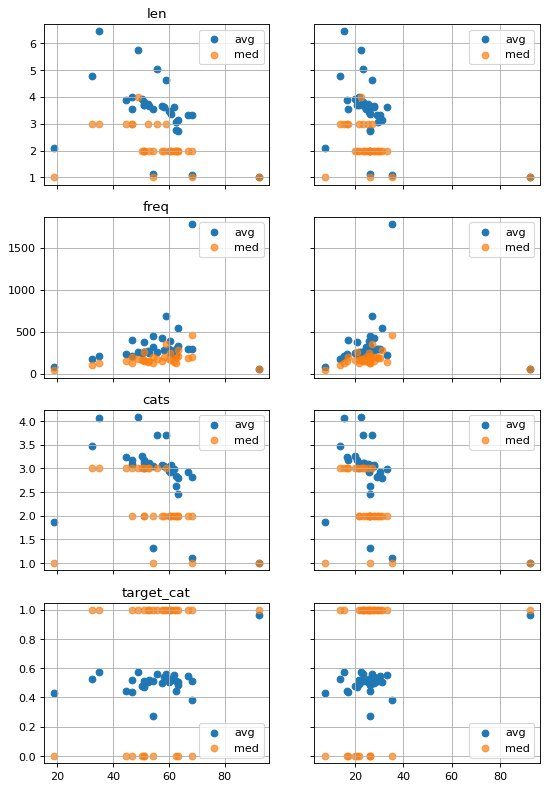

In [31]:
cols=[('avg_len', 
'med_len', ),
('avg_freq',
'med_freq',),
('avg_cats',
'med_cats',),
('avg_target_cat',
'med_target_cat')]

fig, ax=plt.subplots(4, 2, sharex='col', sharey='row', figsize=(8, 12), dpi=80)
for i, (a,b) in enumerate(cols):
    ax[i,0].set_title(a[4:])

    ax[i,0].scatter(cluster_results.test_hit, cluster_results[a], label='avg')
    ax[i,0].scatter(cluster_results.test_hit, cluster_results[b], label='med', alpha=0.7)
    ax[i,0].grid()
    ax[i,0].legend()

    ax[i,1].scatter(cluster_results.test_mrr, cluster_results[a], label='avg')
    ax[i,1].scatter(cluster_results.test_mrr, cluster_results[b], label='med', alpha=0.7)
    ax[i,1].grid()
    ax[i,1].legend()

plt.show()


In [72]:
def get_lenght_distribution(sess_lens, lim=8):
    lens, sizes=np.unique(sess_lens, return_counts=True)
    lim=min(lim, len(lens)-1)
    sizes[lim]=np.sum(sizes[lim:])
    sizes=sizes[:lim+1]
    lens=lens[:lim+1]
    sizes=sizes/sum(sizes)
    return lens, sizes

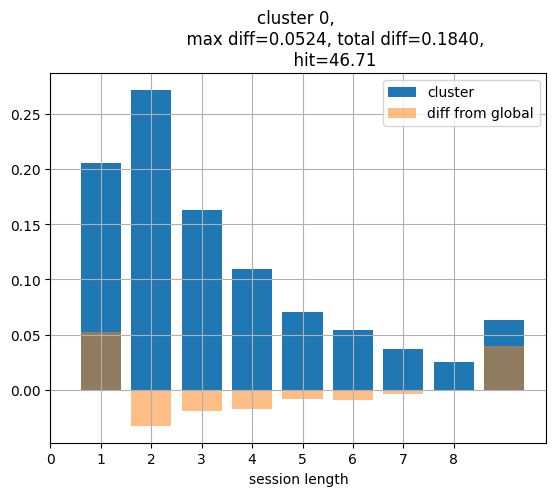

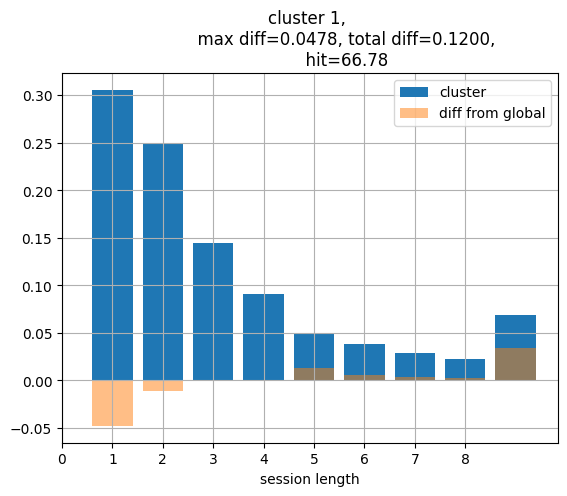

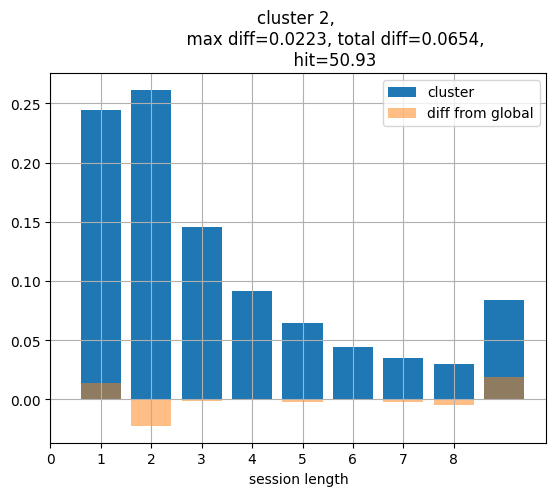

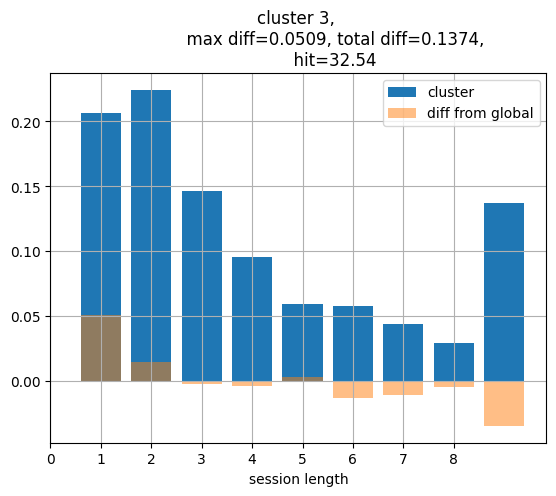

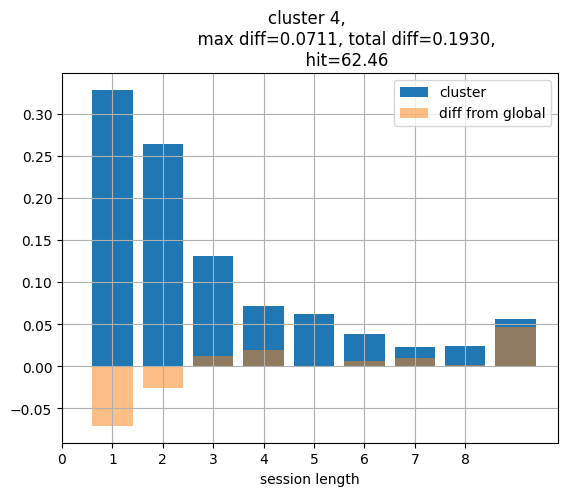

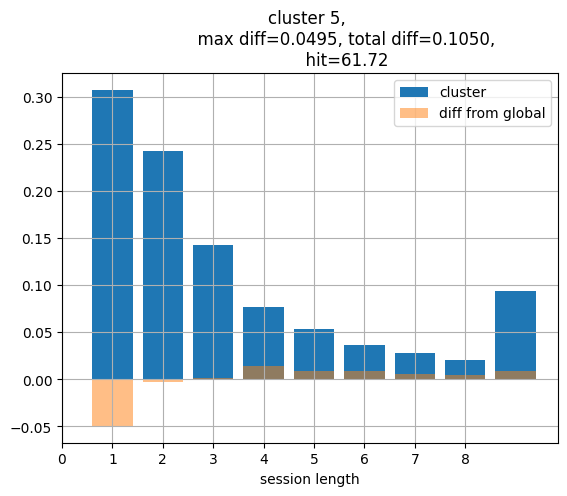

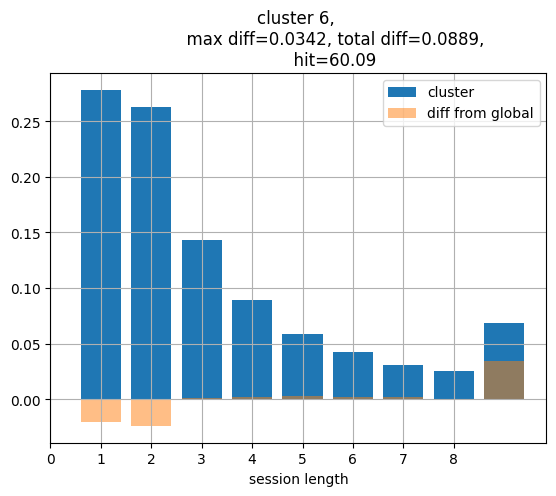

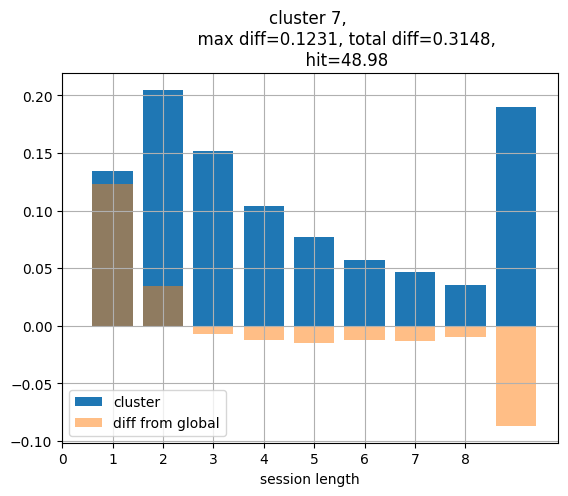

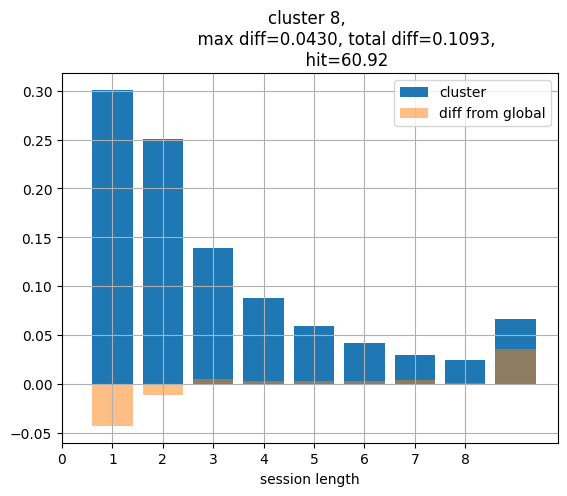

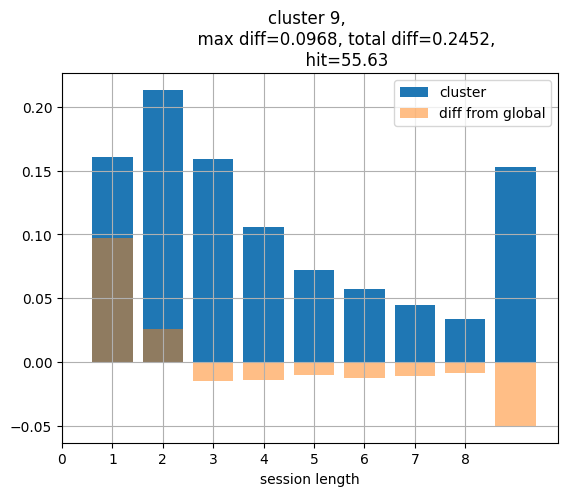

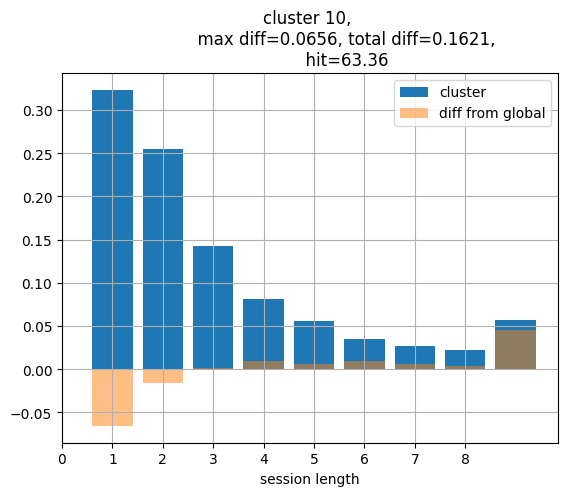

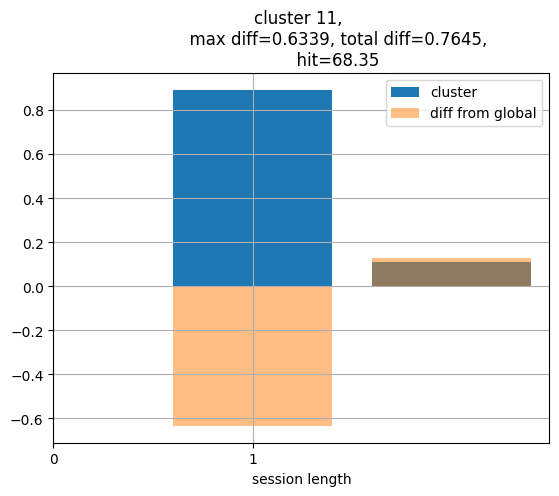

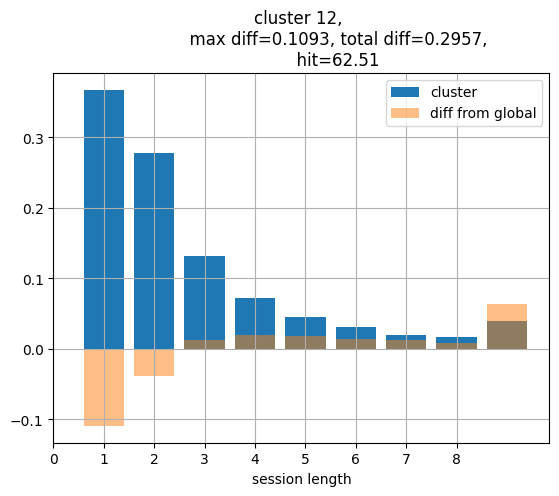

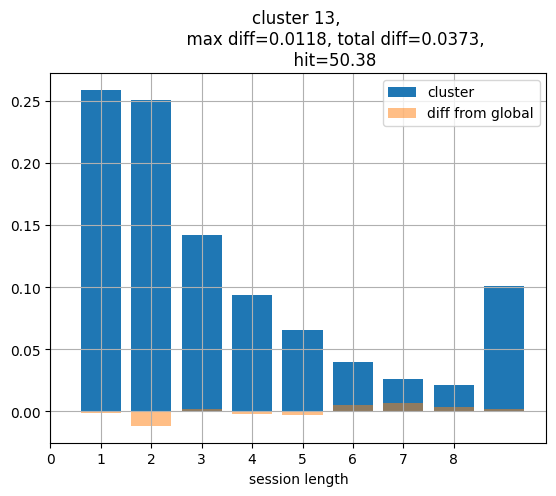

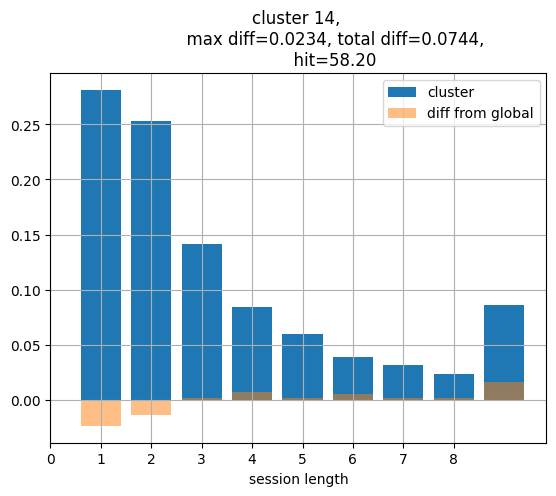

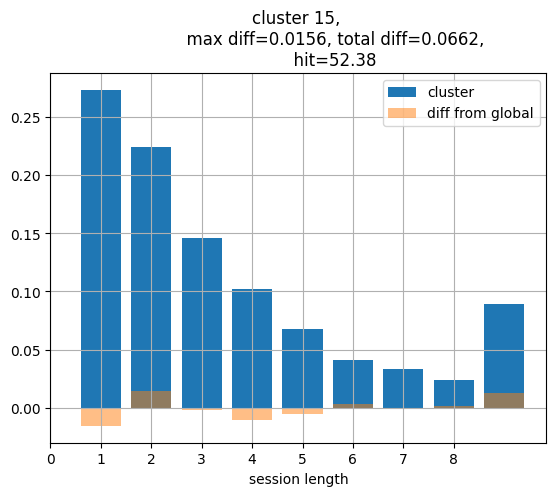

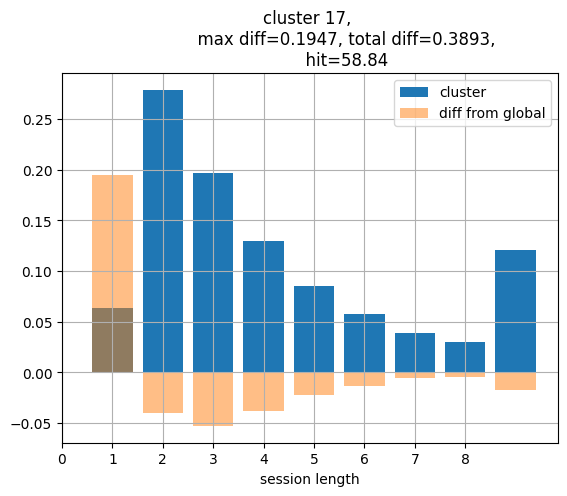

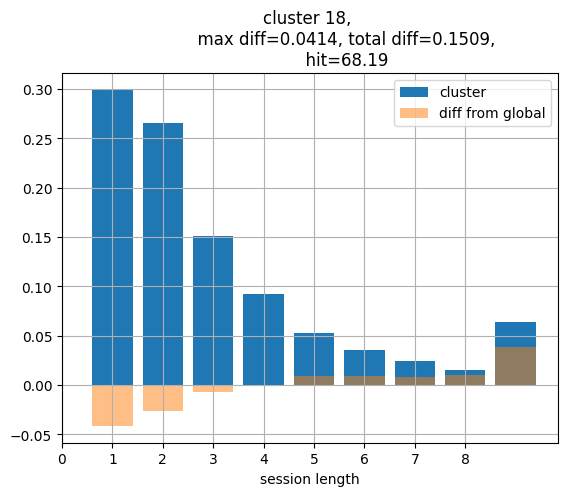

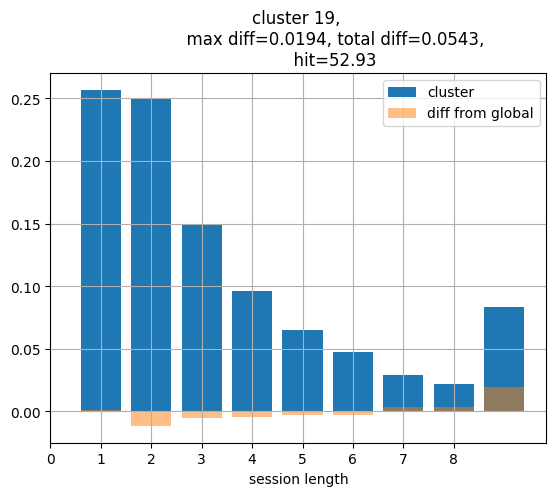

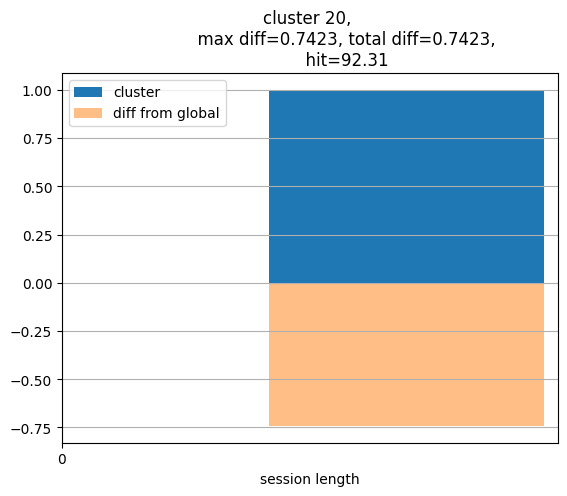

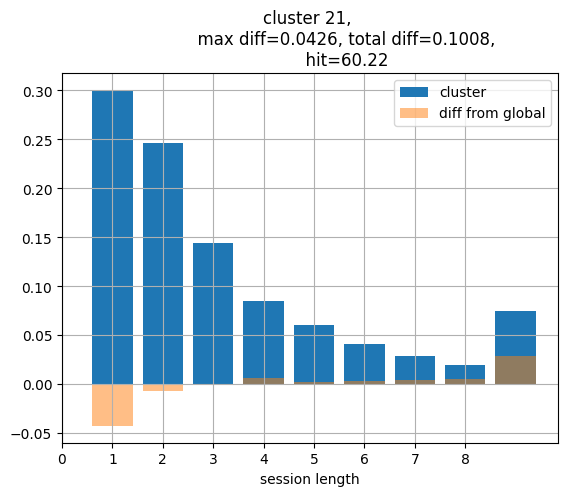

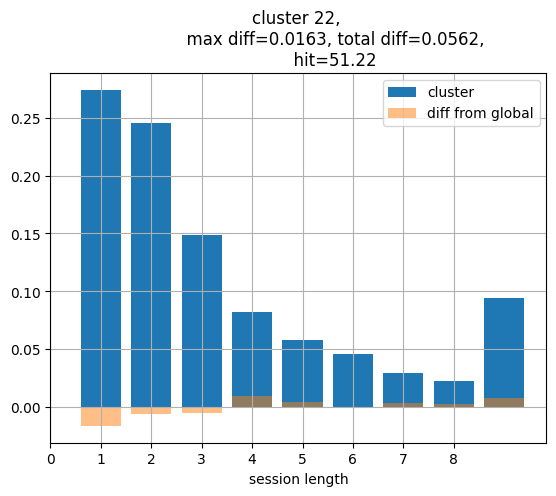

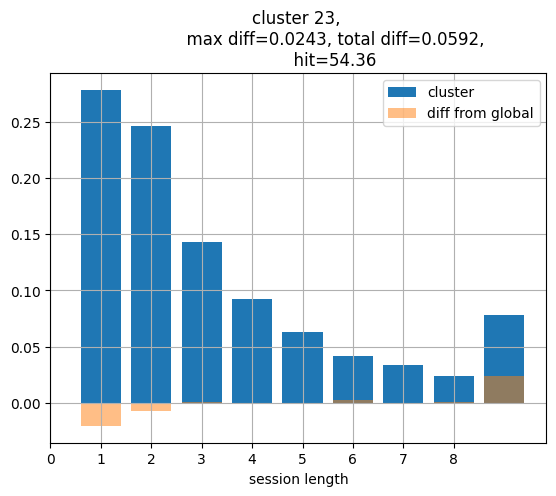

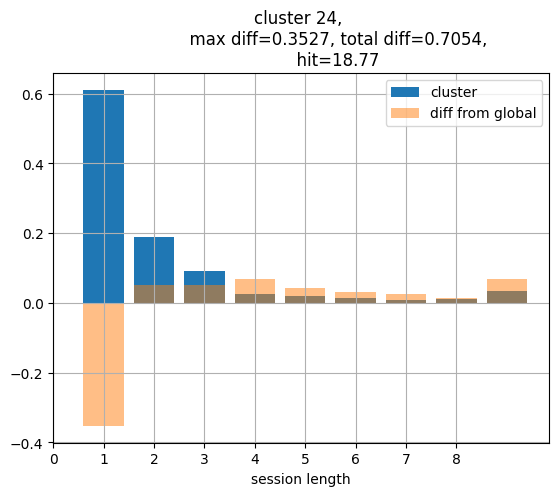

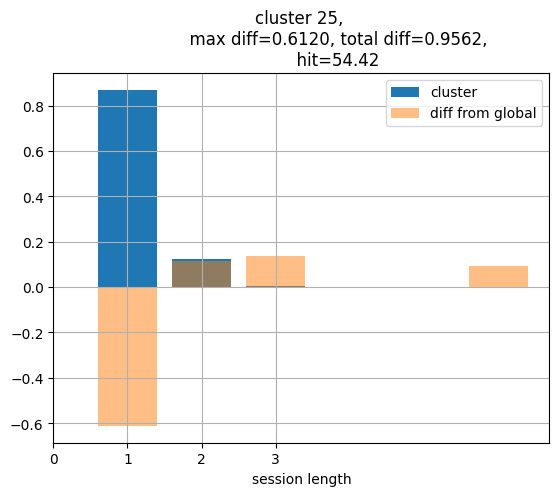

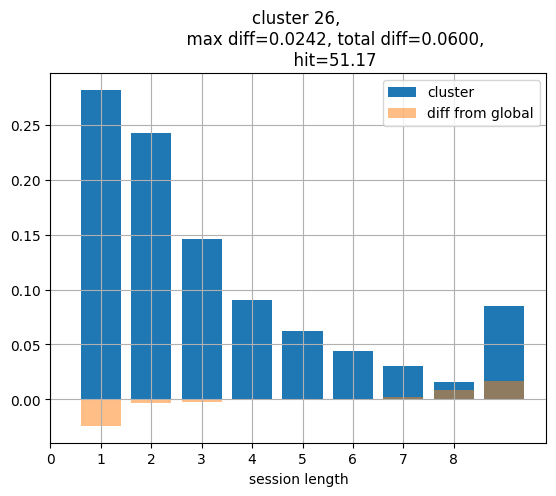

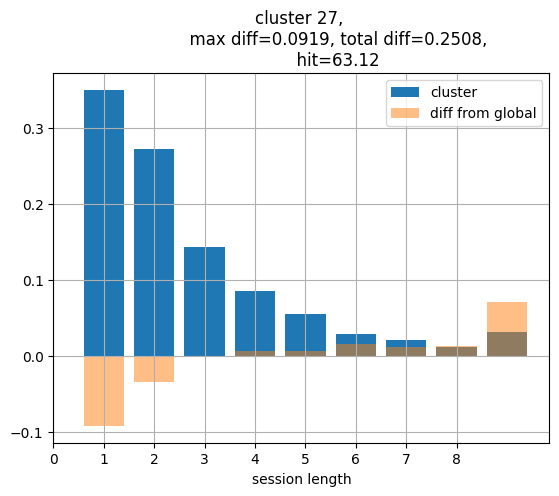

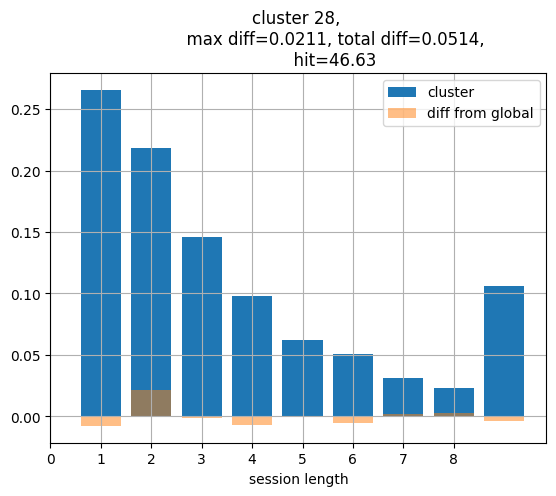

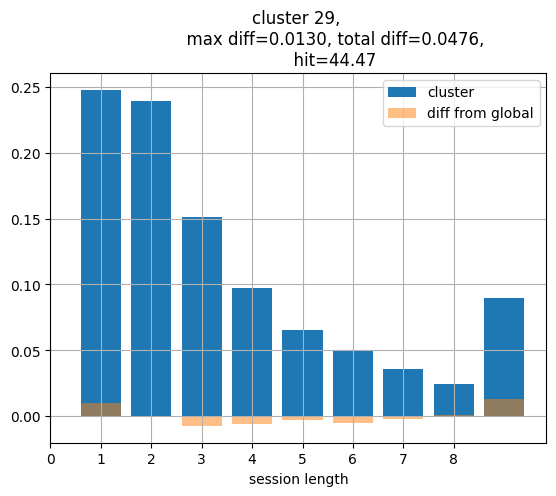

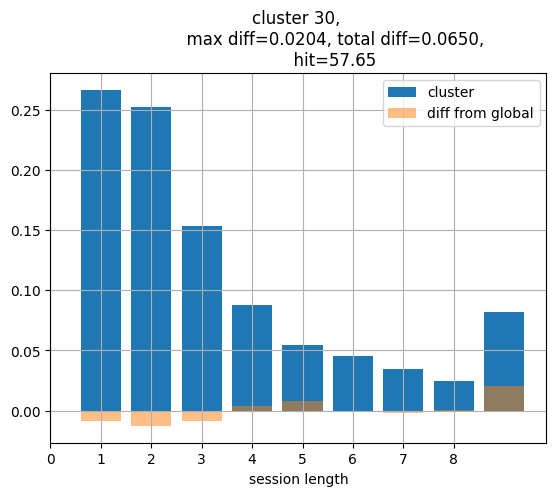

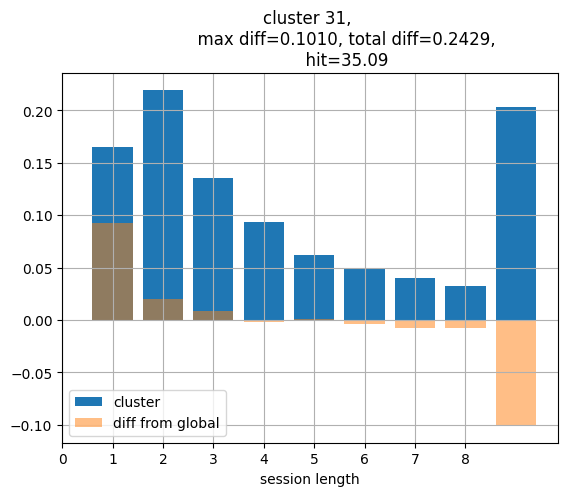

In [75]:
glens, gsizes=get_lenght_distribution(session_len)

#for cluster in cluster_results.loc[cluster_results.global_model_hit<np.average(hit)*100/1.25].cluster:
for cluster in cluster_results.cluster.unique():
    idxs=np.arange(session_labels.shape[0])[session_labels==cluster]
    clens, csizes=get_lenght_distribution(session_len[idxs])

    plt.bar(clens, csizes, label='cluster')
    plt.bar(clens, gsizes[:len(clens)]-csizes, label='diff from global', alpha=0.5)
    plt.grid()
    plt.xlabel('session length')
    plt.xticks(np.arange(len(clens)))
    plt.legend()
    plt.title(f'''cluster {cluster}, 
              max diff={max(np.abs(gsizes[:len(clens)]-csizes)):.4f}, total diff={sum(np.abs(gsizes[:len(clens)]-csizes)):.4f},
              hit={cluster_results.loc[cluster_results.cluster==cluster].test_hit.item():.2f}''')
    plt.show()    